# Data Gathering

Download the data [here](https://www.kaggle.com/datasets/subirbiswas19/freshwater-fish-disease-aquaculture-in-south-asia/data?select=SB-FishDisease). Then import and extract the data. To import the data you can manually upload the data to Colab.

## Import & extract data

In [ ]:
import zipfile

# Location of zip file that want to be extracted
zip_file_path = "/content/SB-FishDisease.zip"

# Path to extract the file
extract_path = "/tmp"

# Extract the archive
zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall(extract_path)
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/SB-FishDisease'

# Data Preprocessing

## Split Data

Install [split-folders](https://pypi.org/project/split-folders/) for splitting data.

In [ ]:
!pip install split-folders

In [ ]:
# run if you want to delete the splitted data
import shutil

try:
    folder_path = '/tmp/fishdata'
    shutil.rmtree(folder_path)
    print('Folder and its content removed')
except:
    print('Folder not deleted')

Folder and its content removed


In [ ]:
import splitfolders

# split data to traininng (80%) and validation (20%)
splitfolders.ratio(base_dir, output="/tmp/fishdata",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 460 files [00:00, 7354.28 files/s]


## Data Normalization & Augmentation

In [ ]:
# use ImageDataGenerator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/tmp/fishdata/train'
valid_dir = '/tmp/fishdata/val'

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, # rescale to normalize the data
                                   rotation_range = 40,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)

valid_datagen = ImageDataGenerator( rescale = 1.0/255 )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode = 'categorical',
                                                    target_size = (224, 224))


validation_generator =  valid_datagen.flow_from_directory(valid_dir,
                                                          class_mode  = 'categorical',
                                                          target_size = (224, 224))

Found 362 images belonging to 7 classes.
Found 95 images belonging to 7 classes.


# Modeling

## Create Model

Load pre-trained model. The pre-trained model we use is MobileNetV2, you can find the model [here](https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2).

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# recommended input image size = (224,224,3)
mobilenetv2_140 = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2"

feature_extractor_model = mobilenetv2_140

In [ ]:
# load the pre-trained model
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=True)

In [ ]:
num_classes = 7

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1792)              4363712   
                                                                 
 dense_8 (Dense)             (None, 512)               918016    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 5814215 (22.18 MB)
Trainable params: 576

## Train Model

In [ ]:
# create checkpoint to save best weights
checkpoint_path='model/my_checkpoint.ckpt'

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1,
                             )

In [ ]:
# Set the training parameters

optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
#optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5)
#optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3, momentum=0.9)

model.compile(optimizer = optimizer ,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 50,
            callbacks=[checkpoint],
            verbose = 2,
            )

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.86567, saving model to model/my_checkpoint.ckpt
12/12 - 21s - loss: 1.9908 - accuracy: 0.2818 - val_loss: 1.8657 - val_accuracy: 0.3789 - 21s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_loss improved from 1.86567 to 1.71229, saving model to model/my_checkpoint.ckpt
12/12 - 6s - loss: 1.7073 - accuracy: 0.3950 - val_loss: 1.7123 - val_accuracy: 0.3789 - 6s/epoch - 497ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.71229 to 1.52357, saving model to model/my_checkpoint.ckpt
12/12 - 9s - loss: 1.5046 - accuracy: 0.5055 - val_loss: 1.5236 - val_accuracy: 0.4632 - 9s/epoch - 764ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.52357 to 1.43020, saving model to model/my_checkpoint.ckpt
12/12 - 7s - loss: 1.3169 - accuracy: 0.5912 - val_loss: 1.4302 - val_accuracy: 0.5579 - 7s/epoch - 600ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.43020 to 1.32560, saving model to model/my_checkpoint.ckpt
12/12 - 6s - loss: 1.2119 - accuracy

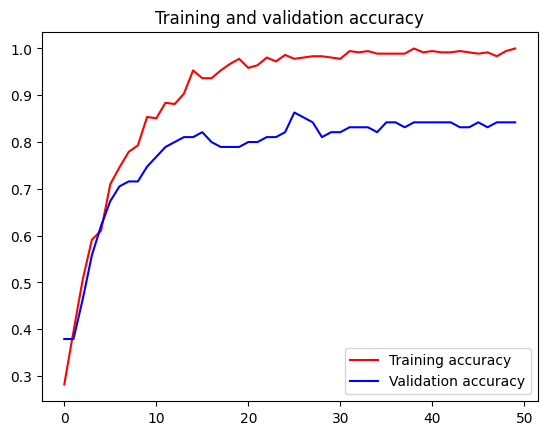

<Figure size 640x480 with 0 Axes>

In [ ]:
# see training plot

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Save Model

In [ ]:
# load weights from checkpoint
model.load_weights(checkpoint_path)

In [ ]:
# Save model in h5 format
model_path = './model/model_mob_l62a86.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# load model
my_reloaded_model = tf.keras.models.load_model(
       (model_path),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

## Evaluate Model

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import pandas as pd

def check_wrong_pred(check_dir, model):

  '''
  This function will check whether images in the check_dir get the wrong
  prediction or not the information about images with wrong predictions will
  stored in the pandas Data Frame

  Parameter:
  - check_dir: directory path of the image that wants to be checked
  - model: the model that used for predicting

  Return:
  - wrong_pred_df: pandas Data Frame that contains information about the image
  that got wrong prediction
  '''

  images_classes_name = ['Bacterial Red disease',
                       'Bacterial diseases - Aeromoniasis',
                       'Bacterial gill disease',
                       'Fungal diseases Saprolegniasis',
                       'Healthy Fish',
                       'Parasitic diseases',
                       'Viral diseases White tail disease']

  real_class_list = []
  test_image_path = []
  predicted_class_list = []
  max_prob_list = []

  for classes in images_classes_name:
    for files in os.listdir(os.path.join(check_dir, classes)):
      file_path = os.path.join(check_dir, classes, files)

      img = image.load_img(file_path, target_size=(224,224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = x / 255

      predicted_class = model.predict(x, batch_size=10)
      max_prob = np.max(predicted_class)
      predicted_class = np.argmax(predicted_class)

      real_class = images_classes_name.index(classes)

      if predicted_class != real_class :
        test_image_path.append(files)
        real_class_list.append(real_class)
        max_prob_list.append(max_prob)
        predicted_class_list.append(predicted_class)

  wrong_pred_dict = {'image_name': test_image_path, 'max_prob':max_prob_list,'real_class': real_class_list, 'predicted_class': predicted_class_list}
  wrong_pred_df = pd.DataFrame(wrong_pred_dict)

  return wrong_pred_df

In [ ]:
check_dir = '/tmp/SB-FishDisease'

false_pred_df = check_wrong_pred(check_dir, model)

In [ ]:
false_pred_df

,image_name,max_prob,real_class,predicted_class
0,Bacterial Red disease (7).png,0.543418,0,2
1,Bacterial Red disease (40).jpg,0.711207,0,1
2,Bacterial Red disease (28).jpg,0.585902,0,4
3,Bacterial diseases - Aeromoniasis (3).jpeg,0.520531,1,6
4,Bacterial diseases - Aeromoniasis (39).jpg,0.562899,1,2
5,Bacterial gill disease (20).jpg,0.924842,2,3
6,Fungal diseases Saprolegniasis (26).jpg,0.864113,3,1
7,Fungal diseases Saprolegniasis (24).jpg,0.893917,3,2
8,Fungal diseases Saprolegniasis (22).jpg,0.467914,3,4
9,Parasitic diseases (15).jpg,0.628454,5,6
